## 5. CRISP-DM: Modeling

## Training and Evaluation without SMOTE

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating initial models:


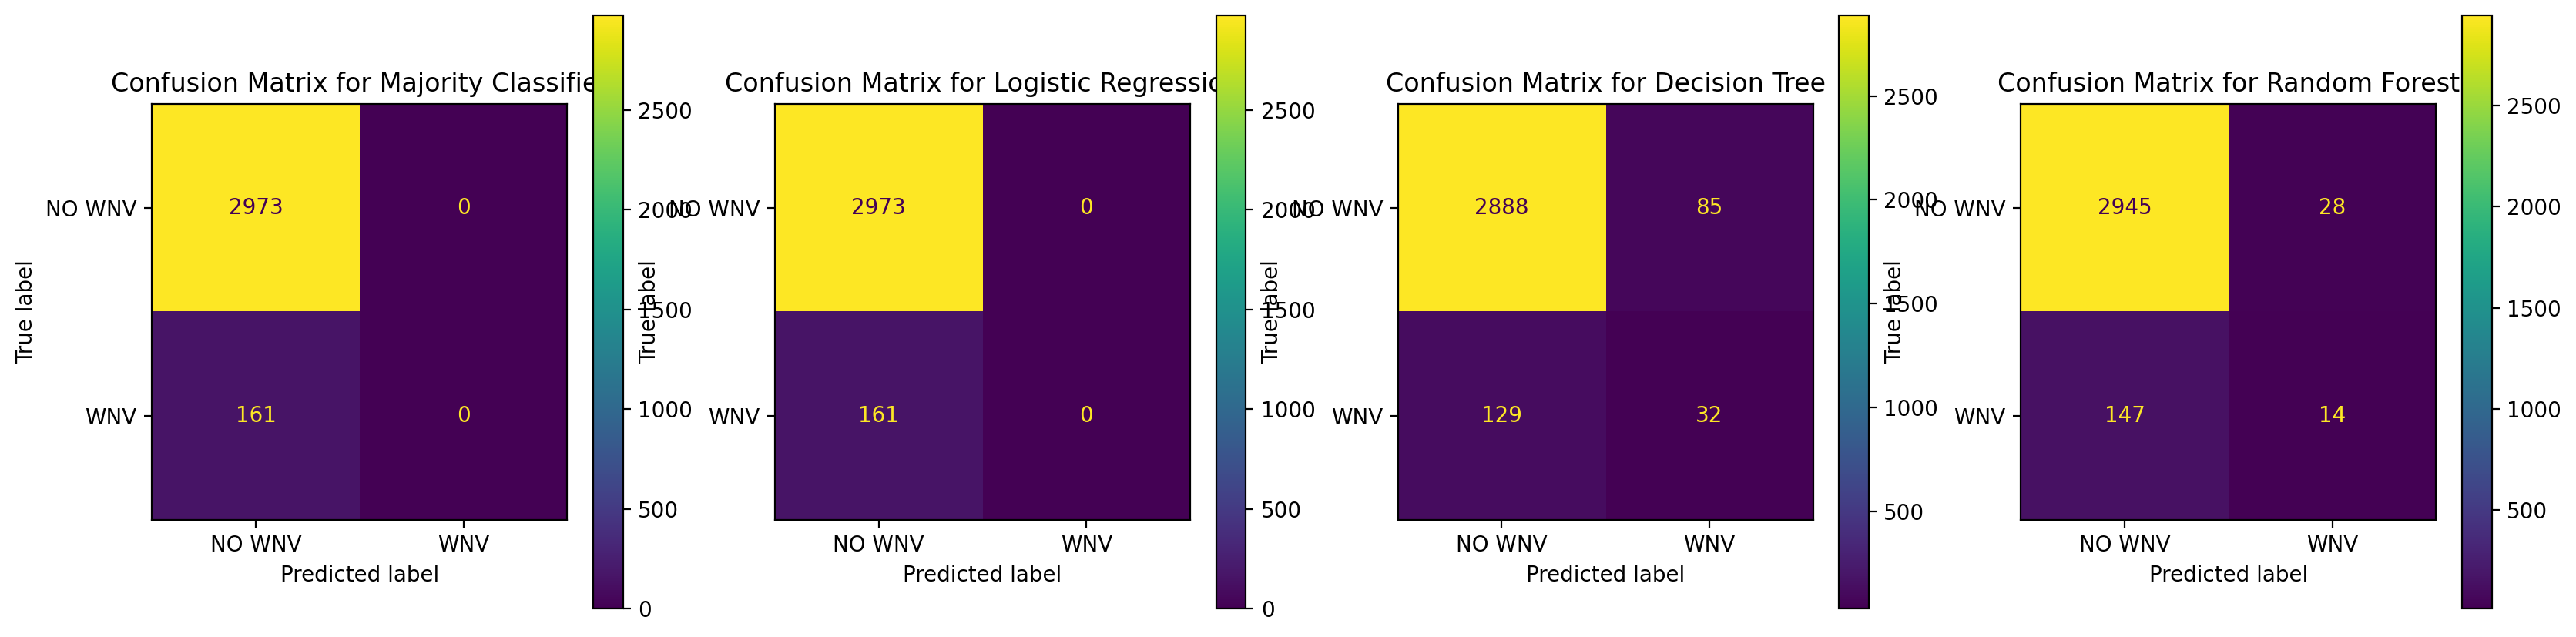

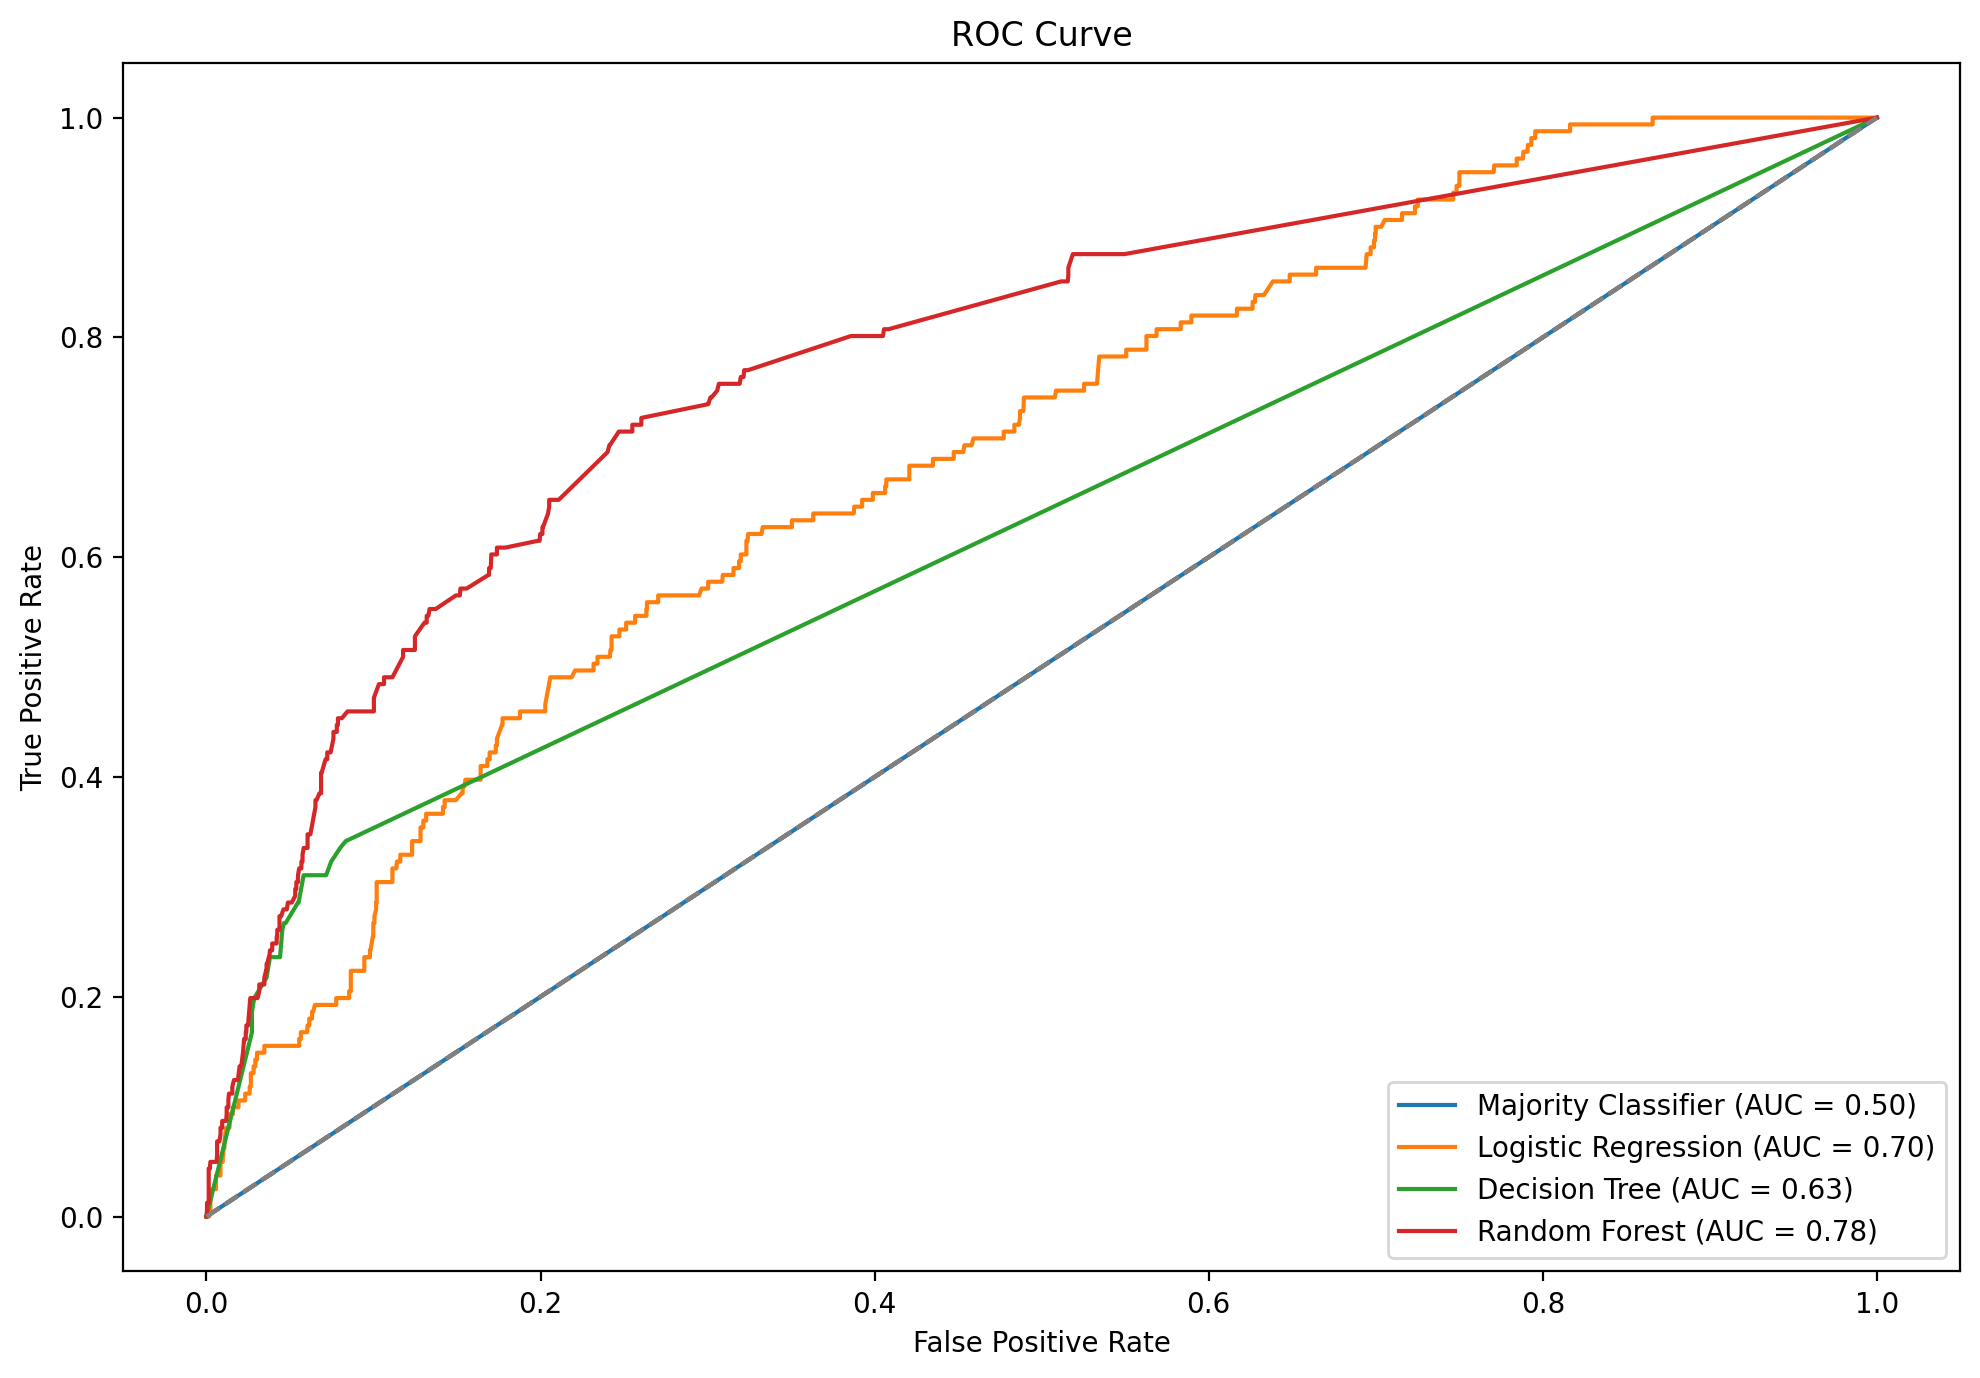

,Accuracy,ROC AUC
Majority Classifier,0.948628,0.500000
Logistic Regression,0.948628,0.695396
Decision Tree,0.931717,0.632782
Random Forest,0.944161,0.780830


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating hyperparameter-tuned models:


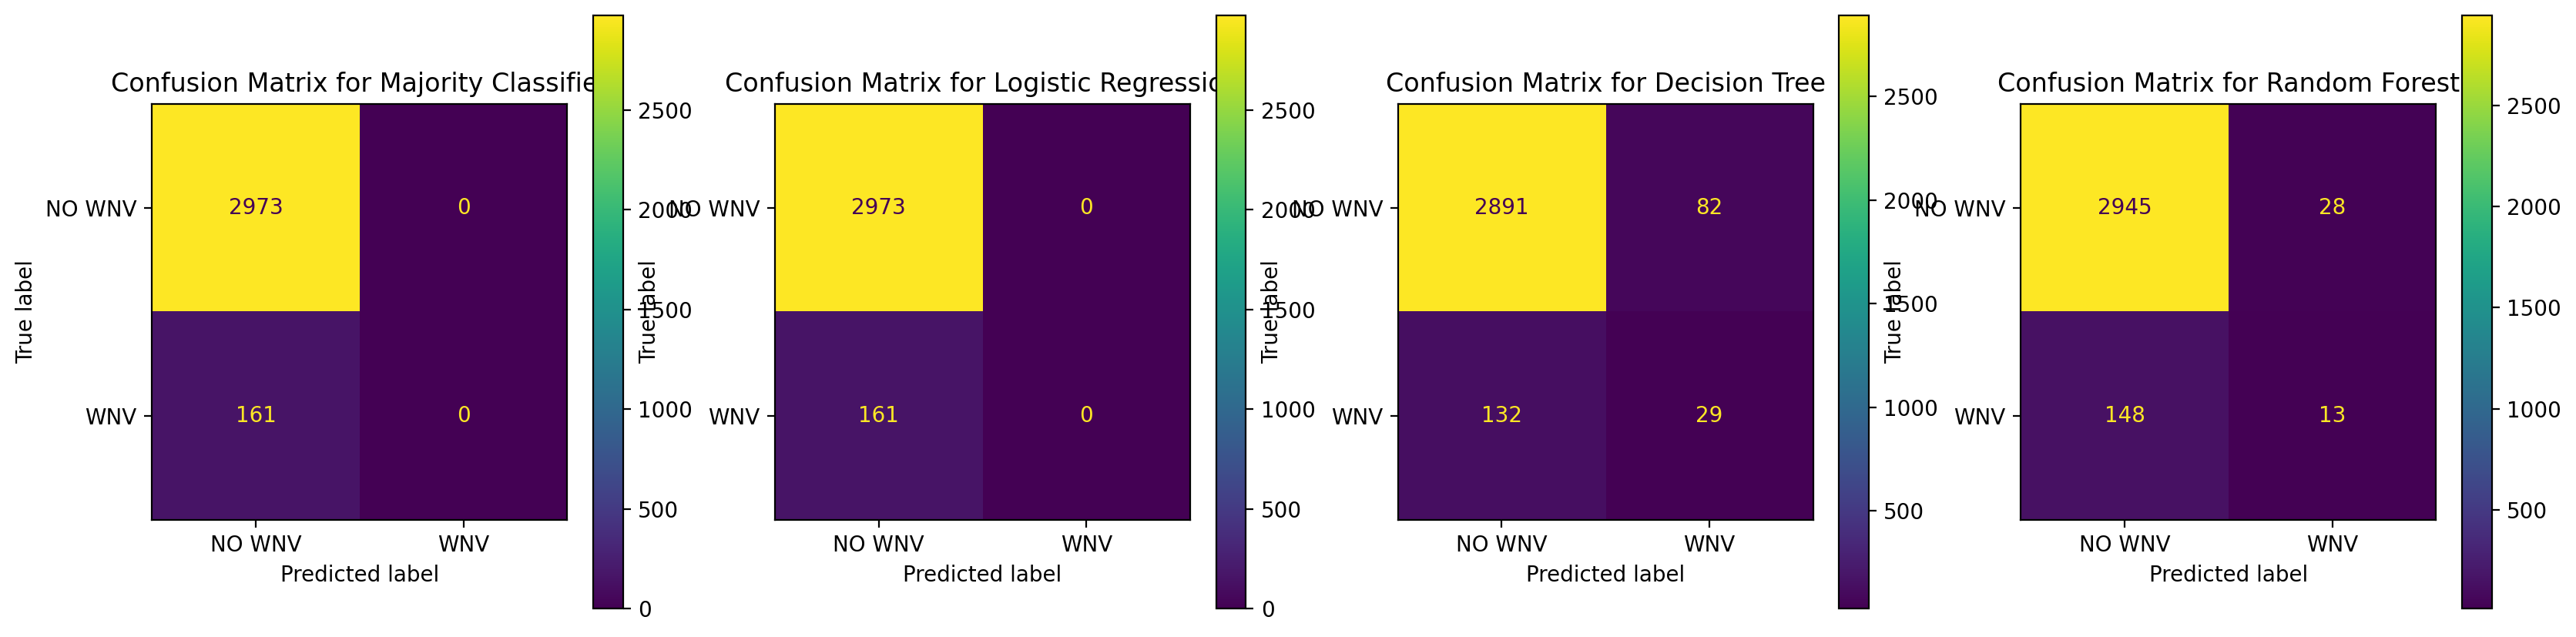

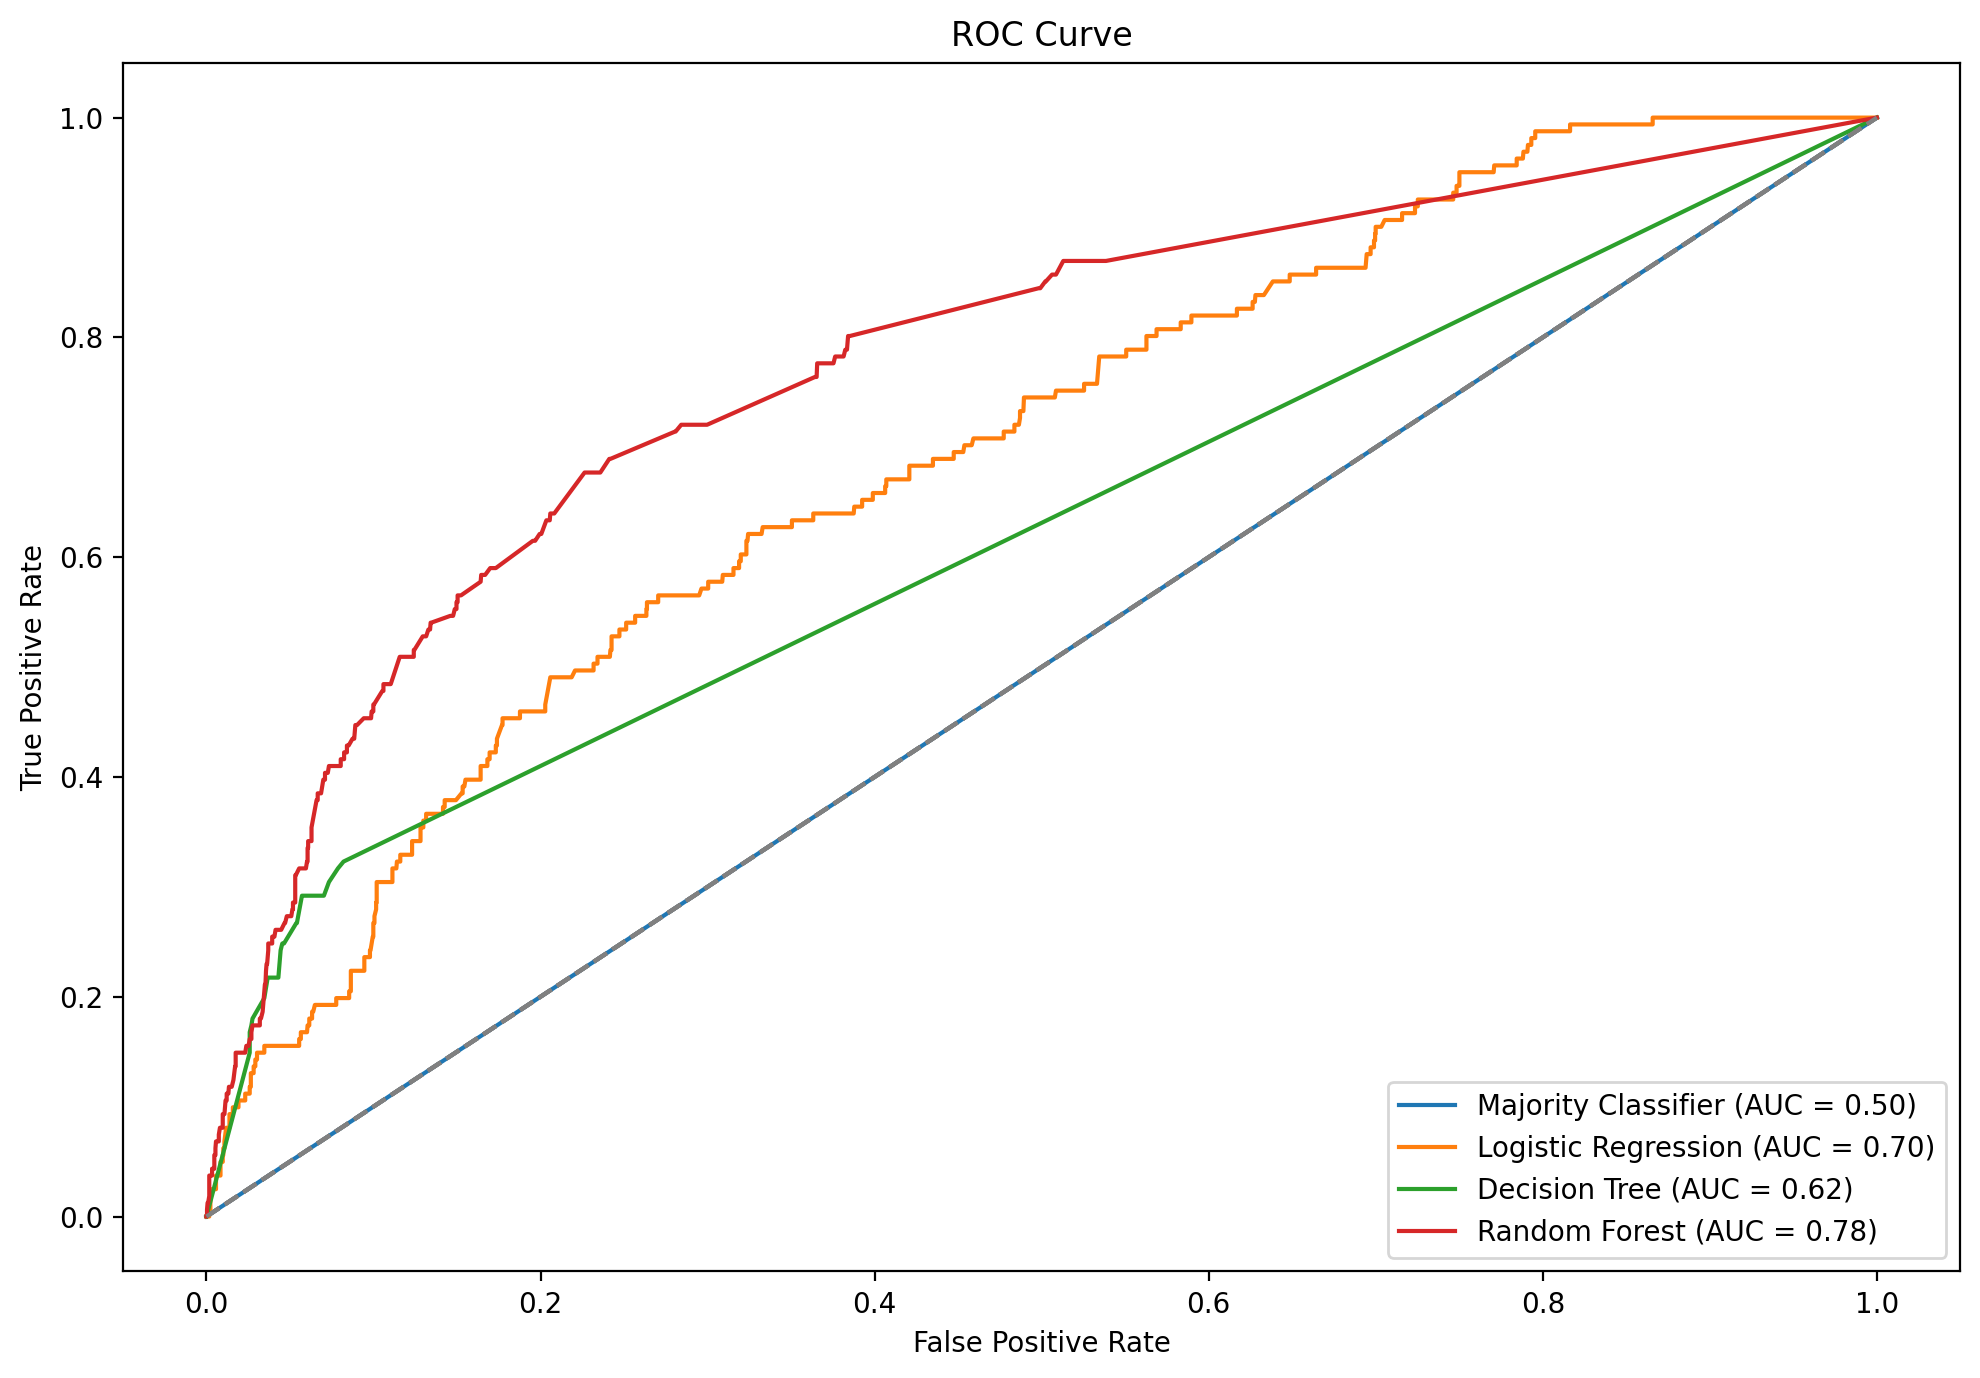

,Accuracy,ROC AUC
Majority Classifier,0.948628,0.500000
Logistic Regression,0.948628,0.695396
Decision Tree,0.931717,0.623700
Random Forest,0.943842,0.775213


Cross-Validation Scores for RandomForestClassifier(): [0.76368601 0.79130334 0.78354732 0.75257059 0.71535034]
Mean CV Score: 0.76


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score
import joblib
import os
from IPython.display import display, Markdown
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Settings for plotting
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'  # High resolution figures")

def prepare_data_for_modeling(train):
    # Data preparation
    X = train.drop(["WnvPresent"], axis=1)
    y = train['WnvPresent']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    
    return X_train, X_test, y_train, y_test

def prepare_models():
    models = {

        'Majority Classifier': DummyClassifier(strategy="most_frequent"),
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier()
    }
    return models

def train_models(models, X_train, y_train):
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

def plot_confusion_matrix(ax, y_true, y_pred, class_names, classifier_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax)
    ax.set_title(f'Confusion Matrix for {classifier_name}')

def plot_roc_curve(ax, y_true, y_proba, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    ax.plot(fpr, tpr, label=f'{classifier_name} (AUC = {auc_score:.2f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')



def evaluate_models(trained_models, X_test, y_test, plot_cm=True, plot_roc=True):
    if not trained_models:
        print("No trained models to evaluate.")
        return pd.DataFrame()  # Return an empty DataFrame if no models are provided
    
    results = {}
    class_names = ['NO WNV', 'WNV']
    fig_cm, axes_cm = plt.subplots(1, len(trained_models), figsize=(5 * len(trained_models), 5))
    fig_roc, ax_roc = plt.subplots(figsize=(10, 7))
    
    for i, (name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A',
            # 'F1 Score': f1_score(y_test, y_pred),
            # 'Precision': precision_score(y_test, y_pred),
            # 'Recall': recall_score(y_test, y_pred)
        }
        
        if plot_cm:
            plot_confusion_matrix(axes_cm[i], y_test, y_pred, class_names, name)
        
        if plot_roc and y_prob is not None:
            plot_roc_curve(ax_roc, y_test, y_prob, name)
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results).T

def hyperparameter_tuning(models, X_train, y_train):
    
    param_grid = {
        'Logistic Regression': {
            'C': [0.1, 1, 10],  
            'solver': ['liblinear'],  
            'penalty': ['l2']  
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20],  
            'min_samples_split': [2, 10],  
            'min_samples_leaf': [1, 5]  
        },
        'Random Forest': {
            'n_estimators': [100, 200, 500, 300],  
            'max_depth': [None, 10, 20],  
            'min_samples_split': [2, 10],  
            'min_samples_leaf': [1, 5]  
        }
    }
    
    best_models = {}
    for name, model in models.items():
        if name in param_grid:
            grid_search = GridSearchCV(model, param_grid=param_grid[name], cv=3, scoring='roc_auc')
            grid_search.fit(X_train, y_train)
            best_models[name] = grid_search.best_estimator_
            print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    return best_models

def cross_validate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f'Cross-Validation Scores for {model}: {scores}')
    print(f'Mean CV Score: {np.mean(scores):.2f}')

def main_workflow():
    display(Markdown(f"## Training and Evaluation without SMOTE"))

    # Load datasets
    train_cleaned = pd.read_csv('../data/cleaned_train_encoded.csv')
    test_cleaned = pd.read_csv('../data/cleaned_test_encoded.csv')
    X_train, X_test, y_train, y_test = prepare_data_for_modeling(train_cleaned)

    # Prepare and train models
    models = prepare_models()
    trained_models = train_models(models, X_train, y_train)
    
    # Evaluate initial models and display results
    print("Evaluating initial models:")
    results_df = evaluate_models(trained_models, X_test, y_test, plot_cm=True, plot_roc=True)
    display(results_df)  # This will display the evaluation metrics in tabular form

    # Perform hyperparameter tuning and re-train models
    best_models = hyperparameter_tuning(models, X_train, y_train)
    # best_models = prepare_models()
    best_trained_models = train_models(best_models, X_train, y_train)
    
    # Evaluate hyperparameter-tuned models and display results
    print("Evaluating hyperparameter-tuned models:")
    best_results_df = evaluate_models(best_trained_models, X_test, y_test, plot_cm=True, plot_roc=True)
    display(best_results_df)  # This will display the evaluation metrics in tabular form

    # Select and cross-validate the best model (adjust as necessary to pick the actual best model)
    if 'Random Forest' in best_trained_models:
        best_model = best_trained_models['Random Forest']
    else:
        best_model = RandomForestClassifier(n_estimators=200, max_depth=20)
        best_model.fit(X_train, y_train)  # Ensure the model is fitted

    cross_validate_model(best_model, X_train, y_train)

main_workflow()
